In [1]:
# -*- coding: utf-8 -*-
# -*- author : Lokman Mheni - Fabio Palmisano -*-
# -*- date : 2024-04-20 -*-
# -*- Last revision: 2024-06-05 *-
# -*- python version : 3.11.9 -*-
# -*- Description: Logistic Regression with new graph-*-

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from itertools import combinations
from collections import defaultdict
from tqdm import tqdm

#!pip install grakel
from grakel import GraphKernel
from grakel.utils import graph_from_networkx
from tqdm import tqdm

ratings = pd.read_csv('data/ratings.csv')
tr = pd.read_csv( 'data/to_read.csv' )

## Preprocessing of Ratings 

<Axes: >

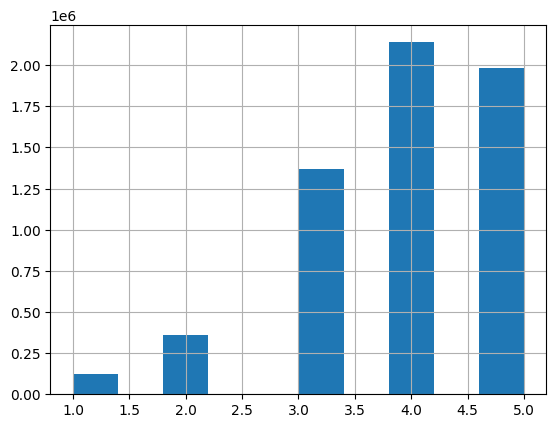

In [3]:
ratings['rating'].hist()

<Axes: >

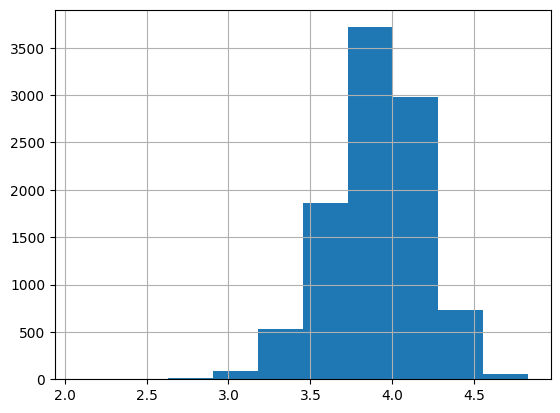

In [4]:
## Can we make the mean ratings per book 
mean_ratings = ratings.groupby('book_id')['rating'].mean()
mean_ratings.hist()

<Axes: xlabel='rating', ylabel='Count'>

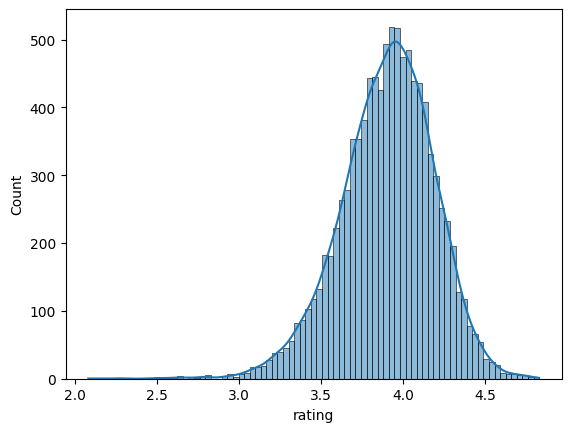

In [5]:
import seaborn as sns
sns.histplot(mean_ratings, kde=True)

In [6]:
mean_ratings

book_id
1        4.279707
2        4.351350
3        3.214341
4        4.329369
5        3.772224
           ...   
9996     4.014184
9997     4.451613
9998     4.323529
9999     3.707692
10000    4.009009
Name: rating, Length: 10000, dtype: float64

<Axes: >

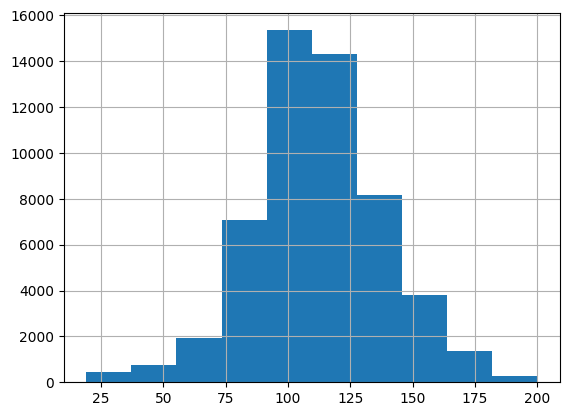

In [7]:
# Can we see the distribution of the number of ratings per user
user_ratings = ratings.groupby('user_id')['rating'].count()
user_ratings.hist()

<Axes: xlabel='rating', ylabel='Count'>

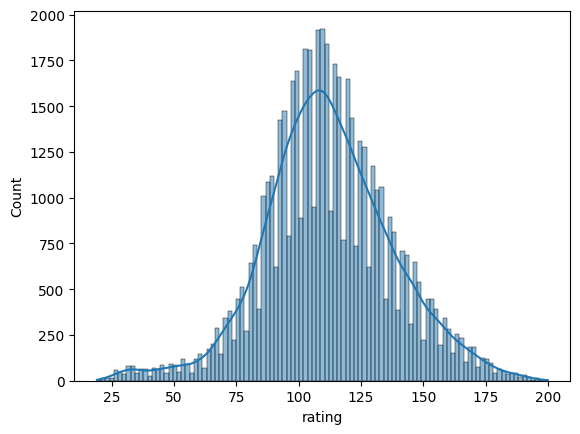

In [8]:
import seaborn as sns
sns.histplot(user_ratings, kde=True)

<Axes: >

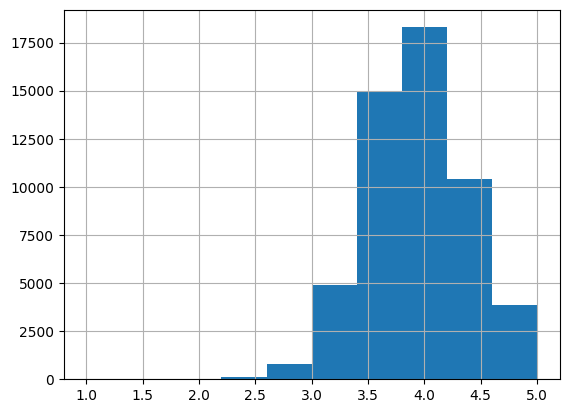

In [9]:
# Can we see the mean ratings distribution per user
mean_user_ratings = ratings.groupby('user_id')['rating'].mean()
mean_user_ratings.hist()


<Axes: xlabel='rating', ylabel='Count'>

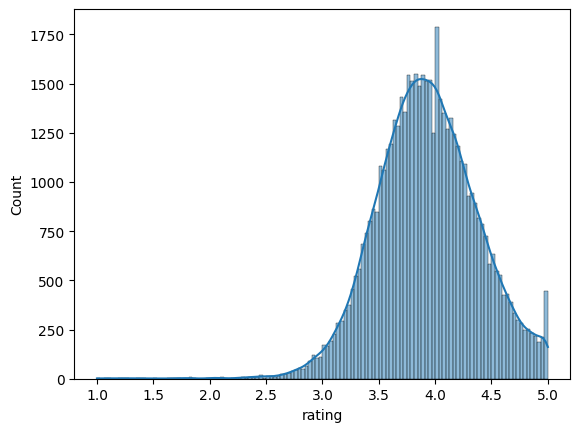

In [10]:
import seaborn as sns
sns.histplot(mean_user_ratings, kde=True)

In [11]:
user_ratings

user_id
1        117
2         65
3         91
4        134
5        100
        ... 
53420    110
53421    110
53422    130
53423     77
53424    133
Name: rating, Length: 53424, dtype: int64

In [12]:
seventyfive_percentile = user_ratings.quantile(0.60)
twentyfive_percentile = user_ratings.quantile(0.40)

In [13]:
seventyfive_percentile, twentyfive_percentile

(117.0, 105.0)

In [14]:
# Oke so now keep only the user that have rated between 25 and 75 percentile (between 96 and 128 books)
user_ratings = user_ratings[(user_ratings >= twentyfive_percentile) & (user_ratings <= seventyfive_percentile)]

In [15]:
user_ratings

user_id
1        117
12       113
14       108
18       109
50       106
        ... 
53398    110
53412    107
53414    116
53420    110
53421    110
Name: rating, Length: 11838, dtype: int64

In [16]:
mean_user_ratings

user_id
1        3.589744
2        4.415385
3        1.736264
4        3.768657
5        4.040000
           ...   
53420    3.345455
53421    4.609091
53422    4.215385
53423    4.454545
53424    4.406015
Name: rating, Length: 53424, dtype: float64

In [17]:
twentyfive_percentile_mean = mean_user_ratings.quantile(0.4)
seventyfive_percentile_mean = mean_user_ratings.quantile(0.6)

twentyfive_percentile_mean, seventyfive_percentile_mean

(3.810810810810811, 4.03030303030303)

In [18]:
# Oke so now keep only the user that have rated between 25 and 75 percentile (between 3.6339 and 4.22321)
mean_user_ratings = mean_user_ratings[(mean_user_ratings >= twentyfive_percentile_mean) & (mean_user_ratings <= seventyfive_percentile_mean)]

mean_user_ratings


user_id
7        3.819355
12       3.867257
17       4.016393
25       4.016667
26       3.990291
           ...   
53394    3.972973
53395    3.914894
53405    3.891892
53408    3.838710
53413    3.908333
Name: rating, Length: 10693, dtype: float64

In [19]:
# Now we can filter and keep only the users that are in both the user_ratings and mean_user_ratings
users = set(user_ratings.index) & set(mean_user_ratings.index)

In [20]:
len(users)

2578

In [21]:
# Oke and now we can keep only the ratings that are in the intersection of the users and books
ratings = ratings[ratings['user_id'].isin(users)]

In [22]:
ratings

,user_id,book_id,rating
822,72,4,5
823,72,55,3
824,72,8,2
825,72,550,5
827,72,1714,5
...,...,...,...
5976135,18147,6753,4
5976136,18147,7892,2
5976322,1670,3371,5
5976323,41342,3175,4


In [23]:
ratings.book_id.nunique()

9823

## Graph Creation (Book to Book based on ratings)


In [24]:
from tqdm import tqdm

# Now we want to create a book to book graph based on the ratings dataset 
# If a book is rated by the same user then we add an edge between the two books
book_to_book = nx.Graph()

# Get a list of unique users
users = ratings['user_id'].unique()

# Loop over users with progress bar
for user in tqdm(users):
    # Get all books rated by this user
    books = ratings[ratings['user_id'] == user]['book_id']
    
    # Loop over all pairs of books
    for book1, book2 in combinations(books, 2):
        if book_to_book.has_edge(book1, book2):
            book_to_book[book1][book2]['weight'] += 1
        else:
            book_to_book.add_edge(book1, book2, weight=1)

  0%|          | 0/2578 [00:00<?, ?it/s]

100%|██████████| 2578/2578 [00:17<00:00, 144.35it/s]


In [25]:
# Can we save this graph in csv file ? 
nx.write_weighted_edgelist(book_to_book, 'book_to_book.edgelist')


In [26]:
print(len(book_to_book.nodes()))
print(len(book_to_book.edges()))

9823
6235818


In [27]:
number_to_read =  tr['book_id'].value_counts()
number_to_read = number_to_read.apply(lambda x: 1 if x >= 50 else 0)
number_to_read

book_id
47      1
143     1
113     1
13      1
11      1
       ..
6297    0
7951    0
4434    0
9124    0
8946    0
Name: count, Length: 9986, dtype: int64

In [28]:
number_to_read.value_counts()

count
0    5641
1    4345
Name: count, dtype: int64

In [29]:
nx.set_node_attributes(book_to_book, number_to_read.to_dict(), 'to_read')

In [30]:
book_to_book.nodes[1]

{'to_read': 1}

In [31]:
#check in G_user_books_sample the proportion of nodes set to label 1 (to read) and which are set to 0 (not to read)
to_read = 0
not_to_read = 0
for node in book_to_book.nodes(data=True):
    if node[1].get('to_read', 0) == 1:
        to_read += 1
    else:
        not_to_read += 1
print(to_read, not_to_read)

4334 5489


In [32]:
graph_labels = nx.get_node_attributes(book_to_book, 'to_read')
graph_labels

{4: 1,
 55: 1,
 8: 1,
 550: 1,
 1714: 1,
 118: 1,
 848: 1,
 867: 1,
 10: 1,
 2136: 1,
 230: 1,
 171: 1,
 471: 1,
 64: 1,
 1159: 1,
 2679: 1,
 1060: 1,
 8457: 0,
 408: 1,
 261: 1,
 1313: 1,
 70: 1,
 26: 1,
 89: 1,
 7: 1,
 92: 1,
 211: 1,
 127: 1,
 76: 1,
 344: 1,
 534: 1,
 101: 1,
 4363: 1,
 2128: 1,
 67: 1,
 544: 1,
 681: 1,
 1644: 1,
 1386: 1,
 3293: 1,
 3579: 1,
 4322: 0,
 407: 1,
 3456: 1,
 33: 1,
 37: 1,
 136: 1,
 66: 1,
 123: 1,
 84: 1,
 626: 0,
 620: 1,
 29: 1,
 75: 1,
 148: 1,
 2671: 0,
 42: 1,
 453: 1,
 1457: 0,
 228: 1,
 212: 1,
 496: 1,
 222: 1,
 919: 1,
 2015: 0,
 343: 1,
 15: 1,
 133: 1,
 225: 1,
 58: 1,
 179: 1,
 32: 1,
 119: 1,
 150: 1,
 468: 1,
 22: 1,
 180: 1,
 102: 1,
 59: 1,
 461: 1,
 198: 1,
 271: 1,
 740: 1,
 795: 1,
 38: 1,
 108: 1,
 955: 0,
 1063: 1,
 1436: 0,
 952: 1,
 308: 1,
 411: 1,
 509: 1,
 8384: 0,
 126: 1,
 100: 1,
 398: 1,
 372: 1,
 8627: 0,
 8218: 0,
 98: 1,
 140: 1,
 6: 1,
 137: 1,
 99: 1,
 1: 1,
 1076: 1,
 1396: 1,
 5328: 0,
 24: 1,
 495: 1,
 45: 1,
 5

In [33]:
degree_centrality = nx.degree_centrality(book_to_book)
degree_centrality

{4: 0.9077580940745266,
 55: 0.7405823661168804,
 8: 0.8457544288332315,
 550: 0.3730401140297292,
 1714: 0.23600081449806556,
 118: 0.5749338220321727,
 848: 0.29403380166972104,
 867: 0.2593158216249236,
 10: 0.8424964365709632,
 2136: 0.22123803705966197,
 230: 0.5358379148849521,
 171: 0.594481775605783,
 471: 0.4098961514966402,
 64: 0.6336794950111994,
 1159: 0.22561596416208513,
 2679: 0.1662594176338831,
 1060: 0.2882305029525555,
 8457: 0.06485440847077988,
 408: 0.3811850946854001,
 261: 0.3580737120749338,
 1313: 0.17654245571166768,
 70: 0.7665444919568316,
 26: 0.8434127468947261,
 89: 0.6575035634290368,
 7: 0.8582773365913255,
 92: 0.5327835471390755,
 211: 0.4693545102830381,
 127: 0.492771329668092,
 76: 0.6368356750152718,
 344: 0.4257788637751985,
 534: 0.401038485033598,
 101: 0.5678069639584606,
 4363: 0.17002647118713093,
 2128: 0.21706373447363062,
 67: 0.6589289350437793,
 544: 0.39106088373040115,
 681: 0.39299531663612297,
 1644: 0.21848910608837305,
 1386: 0.

In [55]:
seed = 42
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

## We want for each node take is degree, closeness centrality, betweeness centrality as features and that make a model to predict if it's a blockbuster (1 in to read) or not 
# Create a DataFrame with the degree, closeness centrality, and betweenness centrality of each node
node_features = pd.DataFrame(index=book_to_book.nodes())
print("Node features1: ", node_features)
# Calculate the degree of each node
node_features['degree'] = pd.Series(dict(book_to_book.degree()))
print("Node features2: ", node_features)
# Calculate the degree centrality of each node
node_features['degree_centrality'] = pd.Series(nx.degree_centrality(book_to_book))
print("Node features3: ", node_features)
# Calculate the eigenvector centrality of each node
node_features['eigenvector_centrality'] = pd.Series(nx.eigenvector_centrality(book_to_book))
print("Node features4: ", node_features)
# Calculate the PageRank of each node
node_features['pagerank'] = pd.Series(nx.pagerank(book_to_book))
print("Node features8: ", node_features)
# Calculate the average neighbor degree of each node
node_features['average_neighbor_degree'] = pd.Series(nx.average_neighbor_degree(book_to_book))
print("Node features9: ", node_features)
# Merge the node features with the graph labels
node_features = node_features.merge(pd.Series(graph_labels, name ='graph_labels'), left_index=True, right_index=True)
print("Node features10: ", node_features)
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)
print("Node features11: ", node_features)
# Train a simple model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

print(y_pred)
# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

#F1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))


# Print the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

Node features1:  Empty DataFrame
Columns: []
Index: [4, 55, 8, 550, 1714, 118, 848, 867, 10, 2136, 230, 171, 471, 64, 1159, 2679, 1060, 8457, 408, 261, 1313, 70, 26, 89, 7, 92, 211, 127, 76, 344, 534, 101, 4363, 2128, 67, 544, 681, 1644, 1386, 3293, 3579, 4322, 407, 3456, 33, 37, 136, 66, 123, 84, 626, 620, 29, 75, 148, 2671, 42, 453, 1457, 228, 212, 496, 222, 919, 2015, 343, 15, 133, 225, 58, 179, 32, 119, 150, 468, 22, 180, 102, 59, 461, 198, 271, 740, 795, 38, 108, 955, 1063, 1436, 952, 308, 411, 509, 8384, 126, 100, 398, 372, 8627, 8218, ...]

[9823 rows x 0 columns]
Node features2:        degree
4       8916
55      7274
8       8307
550     3664
1714    2318
...      ...
6075     104
9971     104
9548     104
9535     104
9015     104

[9823 rows x 1 columns]
Node features3:        degree  degree_centrality
4       8916           0.907758
55      7274           0.740582
8       8307           0.845754
550     3664           0.373040
1714    2318           0.236001
...      ...   

,Real,Predicted
2290,1,1
2683,0,1
7710,0,0
19,1,1
8557,0,0
...,...,...
5954,1,0
2437,1,1
9896,1,0
9200,0,0


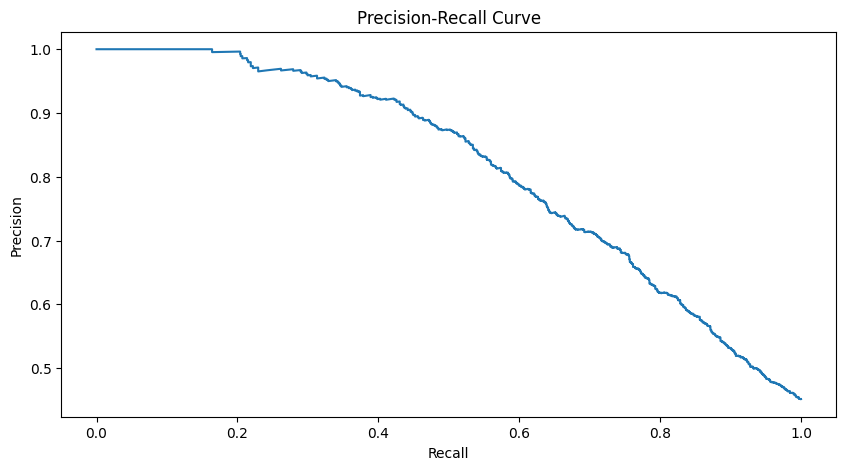

In [56]:
from sklearn.metrics import precision_recall_curve

# Get the probabilities of the positive class
y_scores = model.predict_proba(X_test)[:, 1]

# Get the precision and recall values for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Find the threshold that gives the best F1 score
f1_scores = 2*recall*precision / (recall + precision)
best_threshold = thresholds[np.argmax(f1_scores)]

# Use this threshold to predict the classes
y_pred = (y_scores > best_threshold).astype(int)

# Print the precision-recall curve for the model 
plt.figure(figsize=(10, 5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

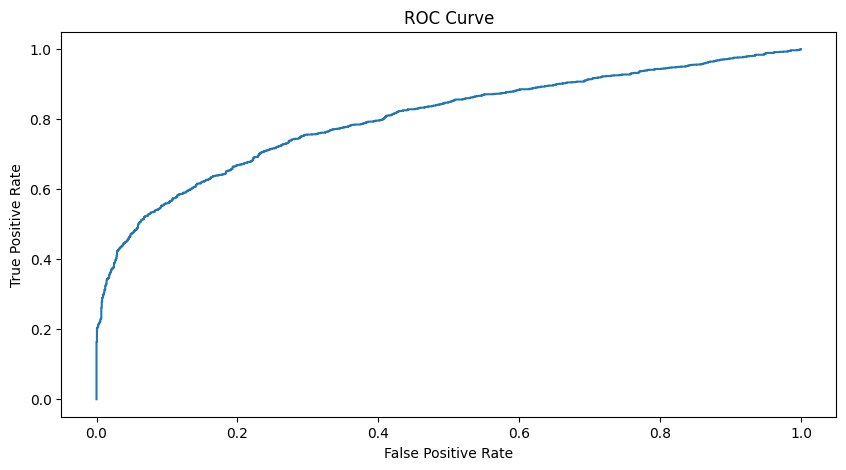

In [57]:
# Plot the ROC curve
from sklearn.metrics import roc_curve

# Get the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plot the ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

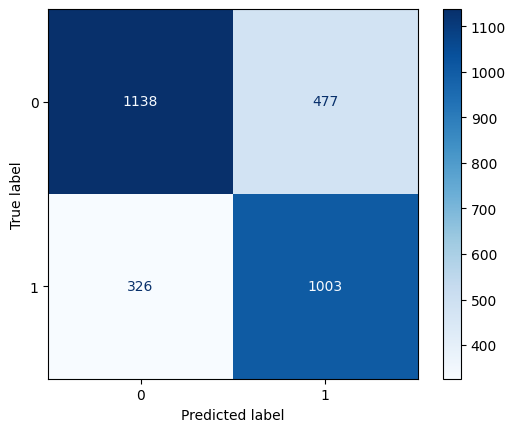

In [58]:
# Plot the matrix of confusion
from sklearn.metrics import ConfusionMatrixDisplay

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.show()


In [86]:
seed = 42
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

## We want for each node take is degree, closeness centrality, betweeness centrality as features and that make a model to predict if it's a blockbuster (1 in to read) or not 
# Create a DataFrame with the degree, closeness centrality, and betweenness centrality of each node
node_features = pd.DataFrame(index=book_to_book.nodes())
print("Node features1: ", node_features)
# Calculate the degree of each node
node_features['degree'] = pd.Series(dict(book_to_book.degree()))
print("Node features2: ", node_features)
# Calculate the degree centrality of each node
node_features['degree_centrality'] = pd.Series(nx.degree_centrality(book_to_book))
print("Node features3: ", node_features)
# Calculate the closeness centrality of each node
node_features['closeness'] = pd.Series(nx.closeness_centrality(book_to_book))
print("Node features4: ", node_features)
# Calculate the betweenness centrality of each node
node_features['betweenness'] = pd.Series(nx.betweenness_centrality(book_to_book))
print("Node features5: ", node_features)
#Calculate the clustering coefficient of each node
node_features['clustering'] = pd.Series(nx.clustering(book_to_book))
print("Node features6: ", node_features)
# Calculate the eigenvector centrality of each node
node_features['eigenvector'] = pd.Series(nx.eigenvector_centrality(book_to_book))
print("Node features7: ", node_features)
# Calculate the pagerank of each node
node_features['pagerank'] = pd.Series(nx.pagerank(book_to_book))
print("Node features8: ", node_features)
# Calculate the average neighbor degree of each node
node_features['average_neighbor_degree'] = pd.Series(nx.average_neighbor_degree(book_to_book))
print("Node features9: ", node_features)
# Merge the node features with the graph labels
node_features = node_features.merge(pd.Series(graph_labels, name ='graph_labels'), left_index=True, right_index=True)
print("Node features10: ", node_features)
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)
print("Node features11: ", node_features)
# Train a simple model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

print(y_pred)
# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

#F1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))


# Print the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

Node features1:  Empty DataFrame
Columns: []
Index: [4, 55, 8, 550, 1714, 118, 848, 867, 10, 2136, 230, 171, 471, 64, 1159, 2679, 1060, 8457, 408, 261, 1313, 70, 26, 89, 7, 92, 211, 127, 76, 344, 534, 101, 4363, 2128, 67, 544, 681, 1644, 1386, 3293, 3579, 4322, 407, 3456, 33, 37, 136, 66, 123, 84, 626, 620, 29, 75, 148, 2671, 42, 453, 1457, 228, 212, 496, 222, 919, 2015, 343, 15, 133, 225, 58, 179, 32, 119, 150, 468, 22, 180, 102, 59, 461, 198, 271, 740, 795, 38, 108, 955, 1063, 1436, 952, 308, 411, 509, 8384, 126, 100, 398, 372, 8627, 8218, ...]

[9823 rows x 0 columns]
Node features2:        degree
4       8916
55      7274
8       8307
550     3664
1714    2318
...      ...
6075     104
9971     104
9548     104
9535     104
9015     104

[9823 rows x 1 columns]
Node features3:        degree  degree_centrality
4       8916           0.907758
55      7274           0.740582
8       8307           0.845754
550     3664           0.373040
1714    2318           0.236001
...      ...   

,Real,Predicted
2290,1,1
2683,0,1
7710,0,0
19,1,1
8557,0,0
...,...,...
5954,1,0
2437,1,1
9896,1,0
9200,0,0


In [87]:
# Now can we try to make different combinaisons of features to see what has the best accuracy and F1 score and store the result in a datafram in order to print the best combinaison
from sklearn.metrics import f1_score

# Create a DataFrame to store the results
results = pd.DataFrame(columns=['features', 'accuracy', 'f1_score'])

# Iterate over all possible combinations of features
for i in range(1, len(node_features.columns) - 1):
    for features in combinations(node_features.columns[:-1], i):
        print(features)
        # Split the data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(node_features[list(features)], node_features['graph_labels'], test_size=0.3, random_state=seed)

        # Train a simple model
        model = LogisticRegression()
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate the accuracy and F1 score of the model
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

       # Append the results to the DataFrame
        results.loc[len(results)] = [features, accuracy, f1]
        print(accuracy, f1)

# Print the results
results.sort_values('f1_score', ascending=False).head(10)

# Print the best combinaison
best_combinaison = results.sort_values('f1_score', ascending=False).iloc[0]
print("Best combinaison of features:")
print(best_combinaison['features'])
print("Accuracy:", best_combinaison['accuracy'])
print("F1 Score:", best_combinaison['f1_score'])

('degree',)
0.7540760869565217 0.690068493150685
('degree_centrality',)
0.7493206521739131 0.6765994741454864
('closeness',)
0.7333559782608695 0.611578426521524
('betweenness',)
0.5485733695652174 0.0
('clustering',)
0.7221467391304348 0.6701612903225806
('eigenvector',)
0.5512907608695652 0.011967090501121916
('pagerank',)
0.5485733695652174 0.0
('average_neighbor_degree',)
0.5485733695652174 0.0
('degree', 'degree_centrality')
0.7540760869565217 0.690068493150685
('degree', 'closeness')
0.7540760869565217 0.690068493150685
('degree', 'betweenness')
0.7540760869565217 0.690068493150685
('degree', 'clustering')
0.7533967391304348 0.6918505942275043
('degree', 'eigenvector')
0.7540760869565217 0.690068493150685
('degree', 'pagerank')
0.7540760869565217 0.690068493150685
('degree', 'average_neighbor_degree')
0.7455842391304348 0.6832980972515855
('degree_centrality', 'closeness')
0.7496603260869565 0.6774617067833698
('degree_centrality', 'betweenness')
0.7493206521739131 0.676599474145

## Try with Neural Network Now

Epoch 1, Loss: 0.9936193619356599
Epoch 2, Loss: 0.7009168229823889
Epoch 3, Loss: 0.6118769608264746
Epoch 4, Loss: 0.6051869682101316
Epoch 5, Loss: 0.5865099588798922
Epoch 6, Loss: 0.5887470343431761
Epoch 7, Loss: 0.5937920837901359
Epoch 8, Loss: 0.5779743950034297
Epoch 9, Loss: 0.5745274035043495
Epoch 10, Loss: 0.5720060955299887


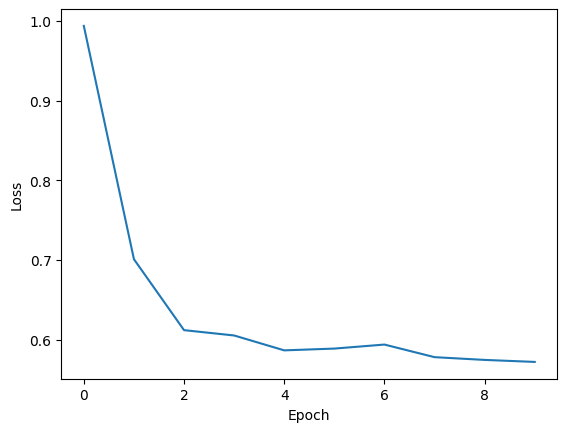

Accuracy: 74.69
F1 Score: 0.65


In [89]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Split the data into train and test sets with the best combinaison of features
X_train, X_test, y_train, y_test = train_test_split(node_features[list(best_combinaison['features'])], node_features['graph_labels'], test_size=0.3, random_state=seed)
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float)

# Create a DataLoader for the training data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

# Define the model
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

# Define the loss function and the optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Initialize a list to store the losses for each epoch
losses = []

# Train the model
for epoch in range(10):
    epoch_losses = []
    for inputs, targets in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Save the loss for this batch
        epoch_losses.append(loss.item())

    # Save the average loss for this epoch
    losses.append(sum(epoch_losses) / len(epoch_losses))
    print(f'Epoch {epoch+1}, Loss: {losses[-1]}')

# Plot the losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs.squeeze() > 0.5).float()
    accuracy = (predicted == y_test_tensor).float().mean()
    print('Accuracy: %.2f' % (accuracy*100))

# Calculate and print the F1 score
f1 = f1_score(y_test_tensor, predicted)
print('F1 Score: %.2f' % f1)

Epoch 1, Loss: 0.717364442417788
Epoch 2, Loss: 0.593412497154502
Epoch 3, Loss: 0.5500479156887809
Epoch 4, Loss: 0.5350732993247898
Epoch 5, Loss: 0.5381518598905829
Epoch 6, Loss: 0.5345046464440435
Epoch 7, Loss: 0.5339095853095831
Epoch 8, Loss: 0.5326990772125333
Epoch 9, Loss: 0.5339981985300086
Epoch 10, Loss: 0.5355843729751054
Epoch 11, Loss: 0.5334240749824879
Epoch 12, Loss: 0.5332387030817741
Epoch 13, Loss: 0.5362511778293654
Epoch 14, Loss: 0.5317506374314774
Epoch 15, Loss: 0.5307690343537996
Epoch 16, Loss: 0.5311255204816198
Epoch 17, Loss: 0.5307536082905392
Epoch 18, Loss: 0.5303641381651856
Epoch 19, Loss: 0.5298435841188874
Epoch 20, Loss: 0.5287236757403196
Epoch 21, Loss: 0.5298460212557815
Epoch 22, Loss: 0.5294408176180928
Epoch 23, Loss: 0.5290772027054499
Epoch 24, Loss: 0.5280035816306292
Epoch 25, Loss: 0.5285949971093687
Epoch 26, Loss: 0.5273315939792367
Epoch 27, Loss: 0.5288152440689331
Epoch 28, Loss: 0.5281495051675065
Epoch 29, Loss: 0.5271800171843

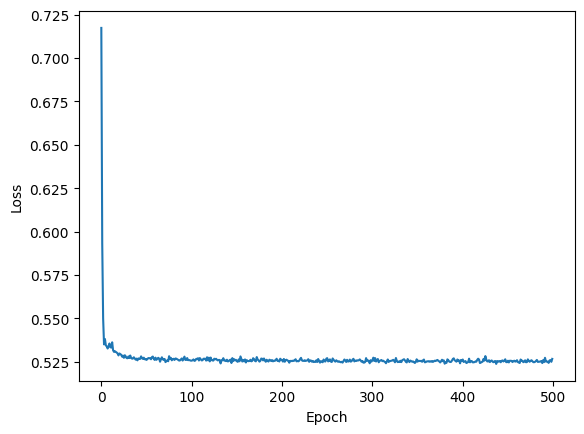

Accuracy: 75.41
F1 Score: 0.69


In [90]:
# Define a more complex model
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)

# Define the loss function and the optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize a list to store the losses for each epoch
losses = []

# Train the model
for epoch in range(500):  # Increase the number of epochs
    epoch_losses = []
    for inputs, targets in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Save the loss for this batch
        epoch_losses.append(loss.item())

    # Save the average loss for this epoch
    losses.append(sum(epoch_losses) / len(epoch_losses))
    print(f'Epoch {epoch+1}, Loss: {losses[-1]}')

# Plot the losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs.squeeze() > 0.5).float()
    accuracy = (predicted == y_test_tensor).float().mean()
    print('Accuracy: %.2f' % (accuracy*100))

# Calculate and print the F1 score
f1 = f1_score(y_test_tensor, predicted)
print('F1 Score: %.2f' % f1)

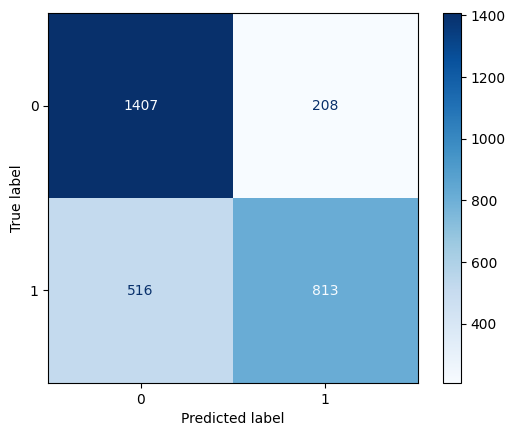

In [94]:
# Plot the matrix of confusion
from sklearn.metrics import ConfusionMatrixDisplay

# Create the confusion matrix
cm = confusion_matrix(y_test_tensor, predicted)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()



In [95]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = torch.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return torch.log_softmax(x, dim=1)

# Assume edge_index is a torch tensor of size [2, num_edges] and x is a torch tensor of size [num_nodes, num_features]
# edge_index[0] and edge_index[1] represent the start and end nodes of edges respectively
# x[i] represents the features of the i-th node
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)

# Get the list of edges
edges = list(book_to_book.edges())

# Create a mapping from the original node indices to the new ones
node_mapping = {node: i for i, node in enumerate(book_to_book.nodes())}

# Remap the edges
edges_remap = [(node_mapping[u], node_mapping[v]) for u, v in edges]

# Create the edge_index tensor
edge_index = torch.tensor(edges_remap, dtype=torch.long).t().contiguous()

# Create the Data object
data = Data(x=X_train_tensor, edge_index=edge_index)

# Initialize the model and the optimizer
model = GCN(num_features=X_train_tensor.size(1), num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Train the model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = torch.nn.functional.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# Test the model
model.eval()
_, pred = model(data).max(dim=1)
correct = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

RuntimeError: index 6867 is out of bounds for dimension 0 with size 6867

In [96]:
# Can we store the data present in the node features dataframe in CSV ? 
node_features.to_csv('data/node_features.csv')


In [34]:
# Read the node features from the CSV file
node_features = pd.read_csv('data/node_features.csv', index_col=0)

In [35]:
books = pd.read_csv( 'data/books.csv' )


In [36]:
node_features

,degree,degree_centrality,closeness,betweenness,clustering,eigenvector,pagerank,average_neighbor_degree,graph_labels
4,8916,0.907758,0.915548,0.004831,0.148205,0.036999,0.002910,1357.947734,1
55,7274,0.740582,0.794018,0.002438,0.183617,0.033192,0.001425,1507.655348,1
8,8307,0.845754,0.866367,0.003663,0.161138,0.035819,0.002213,1414.736126,1
550,3664,0.373040,0.614643,0.000331,0.324653,0.021262,0.000322,1988.850437,1
1714,2318,0.236001,0.566894,0.000098,0.425887,0.015265,0.000151,2334.994392,1
...,...,...,...,...,...,...,...,...,...
6075,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,0
9971,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,0
9548,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,0
9535,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,0


In [43]:
# Check all the columns of the node_features dataframe if they have Nan values
node_features.isnull().sum()

degree                      0
degree_centrality           0
closeness                   0
betweenness                 0
clustering                  0
eigenvector                 0
pagerank                    0
average_neighbor_degree     0
graph_labels                0
average_rating              0
ratings_count               0
text_reviews_count          0
publication_year           20
ratings_1                   0
ratings_2                   0
ratings_3                   0
ratings_4                   0
ratings_5                   0
dtype: int64

In [44]:
# Remove all the columns that have Nan values
node_features = node_features.dropna(axis=1)

In [45]:
book_ids = node_features.index
# Set the index of the books DataFrame to be the book_id
books.set_index('book_id', inplace=True)

# Filter the books DataFrame to only include books that are in node_features
filtered_books = books.loc[book_ids]

# Add the features to node_features
node_features['average_rating'] = filtered_books['average_rating']
node_features['ratings_count'] = filtered_books['ratings_count']
node_features['text_reviews_count'] = filtered_books['work_text_reviews_count']
node_features['publication_year'] = filtered_books['original_publication_year']

for i in range(1, 6):
    column_name = f'ratings_{i}'
    node_features[column_name] = filtered_books[column_name]

KeyError: "None of ['book_id'] are in the columns"

      degree  degree_centrality  closeness  betweenness  clustering  \
4       8916           0.907758   0.915548     0.004831    0.148205   
55      7274           0.740582   0.794018     0.002438    0.183617   
8       8307           0.845754   0.866367     0.003663    0.161138   
550     3664           0.373040   0.614643     0.000331    0.324653   
1714    2318           0.236001   0.566894     0.000098    0.425887   
...      ...                ...        ...          ...         ...   
6075     104           0.010588   0.426506     0.000000    1.000000   
9971     104           0.010588   0.426506     0.000000    1.000000   
9548     104           0.010588   0.426506     0.000000    1.000000   
9535     104           0.010588   0.426506     0.000000    1.000000   
9015     104           0.010588   0.502327     0.000000    1.000000   

      eigenvector  pagerank  average_neighbor_degree  graph_labels  \
4        0.036999  0.002910              1357.947734             1   
55     

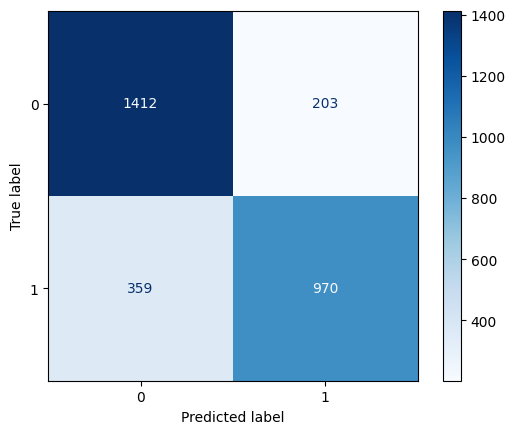

In [48]:
# Split the data into train and test sets
seed = 42
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
print(node_features)
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)

# Train a simple model
model = LogisticRegression(max_iter = 10000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Calculate the F1 score of the model
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

# Print the confusion matrix
confusion_matrix(y_test, y_pred)


# Print the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

# Plot the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()




In [80]:
# BE CAREFUL THIS CELL TAKES A LOT OF TIME TO RUN
from tqdm import tqdm

# Create a DataFrame to store the results
results = pd.DataFrame(columns=['features', 'accuracy', 'f1_score'])
columns_without_labels = [col for col in node_features.columns if col != 'graph_labels']

# Calculate total combinations
total_combinations = sum(1 for _ in combinations(columns_without_labels, i) for i in range(1, len(node_features.columns) - 1))

with tqdm(total=total_combinations, desc="Processing combinations") as pbar:
    # Iterate over all possible combinations of features
    for i in range(1, len(node_features.columns) - 1):
        for features in combinations(columns_without_labels, i):
            # Split the data into train and test sets
            X_train, X_test, y_train, y_test = train_test_split(node_features[list(features)], node_features['graph_labels'], test_size=0.3, random_state=seed)

            # Train a simple model
            model = LogisticRegression(max_iter = 10000)
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)

            # Calculate the accuracy and F1 score of the model
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            # Append the results to the DataFrame
            results.loc[len(results)] = [features, accuracy, f1]

            # Update the progress bar
            pbar.update()

# Print the results
results.sort_values('f1_score', ascending=False).head(10)

# Print the best combination
best_combination = results.sort_values('f1_score', ascending=False).iloc[0]
print("Best combination of features:")
print(best_combination['features'])
print("Accuracy:", best_combination['accuracy'])
print("F1 Score:", best_combination['f1_score'])

Processing combinations:  60%|██████    | 39381/65520 [43:11<43:26, 10.03it/s]  

# Try Some Neural Networks

In [53]:
best_combination = list(('degree', 'degree_centrality', 'betweenness', 'clustering', 'eigenvector', 'pagerank', 'average_rating', 'ratings_count', 'text_reviews_count', 'ratings_1', 'ratings_3', 'ratings_4', 'ratings_5'))
best_combination

['degree',
 'degree_centrality',
 'betweenness',
 'clustering',
 'eigenvector',
 'pagerank',
 'average_rating',
 'ratings_count',
 'text_reviews_count',
 'ratings_1',
 'ratings_3',
 'ratings_4',
 'ratings_5']

In [58]:
#train a simple regression model with the best combination of features
# Split the data into train and test sets with the best combination of features
X_train, X_test, y_train, y_test = train_test_split(node_features[best_combination], node_features['graph_labels'], test_size=0.3, random_state=seed)
# Train a simple model
model = LogisticRegression(max_iter = 10000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Calculate the F1 score of the model
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)



Accuracy: 0.8206521739130435
F1 Score: 0.7872683319903304


In [75]:
# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(node_features[best_combination], node_features['graph_labels'], test_size=0.3, random_state=seed)

# Train a simple model
model = RandomForestClassifier(random_state=seed)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

print(y_pred)
# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

#F1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))


# Print the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

[1 1 0 ... 0 0 0]
Accuracy:  0.8291440217391305
F1 Score:  0.800476001586672


,Real,Predicted
2290,1,1
2683,0,1
7710,0,0
19,1,1
8557,0,0
...,...,...
5954,1,1
2437,1,1
9896,1,0
9200,0,0


In [65]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method for sampling data points (with or without replacement)
}

# Create a base model
rf = RandomForestClassifier(random_state=seed)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters: ", best_params)

# Train the model using the best parameters
best_model = RandomForestClassifier(**best_params, random_state=seed)
best_model.fit(X_train, y_train)

# Make predictions with the best model
y_pred_best = best_model.predict(X_test)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred_best))
print("F1 Score: ", f1_score(y_test, y_pred_best))

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best parameters:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Accuracy:  0.8301630434782609
F1 Score:  0.7999999999999999


In [76]:
# Train the model with the best parameters of random forest and standardize the features with the best combination of features
from sklearn.preprocessing import StandardScaler
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a simple model
best_model = RandomForestClassifier(**best_params, random_state=seed)
best_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_best = best_model.predict(X_test_scaled)

# Calculate the accuracy of the model

accuracy_score(y_test, y_pred_best)

#F1 score

f1_score(y_test, y_pred_best)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred_best))
print("F1 Score: ", f1_score(y_test, y_pred_best))



Accuracy:  0.8325407608695652
F1 Score:  0.802721088435374


In [78]:
node_features

,degree,degree_centrality,closeness,betweenness,clustering,eigenvector,pagerank,average_neighbor_degree,graph_labels,average_rating,ratings_count,text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
4,8916,0.907758,0.915548,0.004831,0.148205,0.036999,0.002910,1357.947734,1,4.25,3198671,72586,60427,117415,446835,1001952,1714267
55,7274,0.740582,0.794018,0.002438,0.183617,0.033192,0.001425,1507.655348,1,3.97,1022601,20095,26367,60328,219895,389379,383166
8,8307,0.845754,0.866367,0.003663,0.161138,0.035819,0.002213,1414.736126,1,3.79,2044241,44920,109383,185520,455042,661516,709176
550,3664,0.373040,0.614643,0.000331,0.324653,0.021262,0.000322,1988.850437,1,4.17,133271,11843,1566,4451,22055,58252,61340
1714,2318,0.236001,0.566894,0.000098,0.425887,0.015265,0.000151,2334.994392,1,3.98,58836,1750,364,1910,14429,27340,18137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,0,4.02,20109,2068,558,1222,4601,8016,9217
9971,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,0,3.87,10989,881,395,1182,4378,6060,5591
9548,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,0,4.25,15460,2179,241,504,1952,5193,7592
9535,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,0,4.33,20070,1407,146,512,2643,7784,11748


Epoch 1, Loss: 45.81132033148477
Epoch 2, Loss: 43.803294567729154
Epoch 3, Loss: 43.74031007456225
Epoch 4, Loss: 43.67732558139535
Epoch 5, Loss: 43.74031007456225
Epoch 6, Loss: 43.803294567729154
Epoch 7, Loss: 43.74031007456225
Epoch 8, Loss: 43.74031007456225
Epoch 9, Loss: 43.74031007456225
Epoch 10, Loss: 43.74031007456225
Epoch 11, Loss: 43.74031007456225
Epoch 12, Loss: 43.67732558139535
Epoch 13, Loss: 43.67732558139535
Epoch 14, Loss: 43.67732558139535
Epoch 15, Loss: 43.74031007456225
Epoch 16, Loss: 43.74031007456225
Epoch 17, Loss: 43.803294567729154
Epoch 18, Loss: 43.74031007456225
Epoch 19, Loss: 43.67732558139535
Epoch 20, Loss: 43.67732558139535
Epoch 21, Loss: 43.866279069767444
Epoch 22, Loss: 43.67732558139535
Epoch 23, Loss: 43.74031007456225
Epoch 24, Loss: 43.74031007456225
Epoch 25, Loss: 43.803294567729154
Epoch 26, Loss: 43.803294567729154
Epoch 27, Loss: 43.866279069767444
Epoch 28, Loss: 43.74031007456225
Epoch 29, Loss: 43.67732558139535
Epoch 30, Loss: 

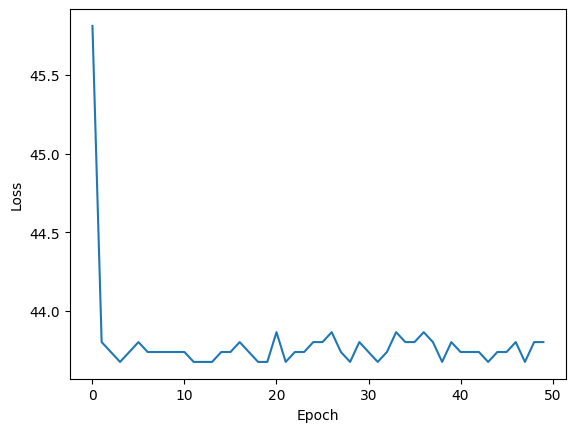

Accuracy: 54.86
F1 Score: 0.00


In [79]:
# Try With GNN 
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Split the data into train and test sets with the best combinaison of features
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis = 1), node_features['graph_labels'], test_size=0.3, random_state=seed)
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float)

# Create a DataLoader for the training data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

# Define the model
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

# Define the loss function and the optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Initialize a list to store the losses for each epoch
losses = []

# Train the model
for epoch in range(50):
    epoch_losses = []
    for inputs, targets in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Save the loss for this batch
        epoch_losses.append(loss.item())

    # Save the average loss for this epoch
    losses.append(sum(epoch_losses) / len(epoch_losses))
    print(f'Epoch {epoch+1}, Loss: {losses[-1]}')

# Plot the losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs.squeeze() > 0.5).float()
    accuracy = (predicted == y_test_tensor).float().mean()
    print('Accuracy: %.2f' % (accuracy*100))

# Calculate and print the F1 score
f1 = f1_score(y_test_tensor, predicted)
print('F1 Score: %.2f' % f1)

Epoch 1, Loss: 56.25968991656636
Epoch 2, Loss: 56.32267441860465
Epoch 3, Loss: 56.25968991656636
Epoch 4, Loss: 56.19670542339946
Epoch 5, Loss: 56.19670542339946
Epoch 6, Loss: 56.19670542339946
Epoch 7, Loss: 56.19670542339946
Epoch 8, Loss: 56.25968991656636
Epoch 9, Loss: 56.32267441860465
Epoch 10, Loss: 56.32267441860465
Epoch 11, Loss: 56.32267441860465
Epoch 12, Loss: 56.19670542339946
Epoch 13, Loss: 56.32267441860465
Epoch 14, Loss: 56.19670542339946
Epoch 15, Loss: 56.25968991656636
Epoch 16, Loss: 56.19670542339946
Epoch 17, Loss: 56.25968991656636
Epoch 18, Loss: 56.32267441860465
Epoch 19, Loss: 56.25968991656636
Epoch 20, Loss: 56.32267441860465
Epoch 21, Loss: 56.19670542339946
Epoch 22, Loss: 56.133720930232556
Epoch 23, Loss: 56.19670542339946
Epoch 24, Loss: 56.19670542339946
Epoch 25, Loss: 56.25968991656636
Epoch 26, Loss: 56.133720930232556
Epoch 27, Loss: 56.32267441860465
Epoch 28, Loss: 56.25968991656636
Epoch 29, Loss: 56.25968991656636
Epoch 30, Loss: 56.19

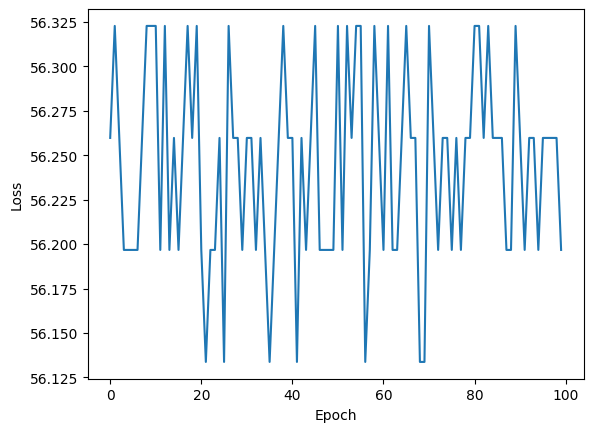

Accuracy: 45.14
F1 Score: 0.62


In [71]:
# Define a more complex model
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)

# Define the loss function and the optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize a list to store the losses for each epoch
losses = []

# Train the model
for epoch in range(100):  # Increase the number of epochs
    epoch_losses = []
    for inputs, targets in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Save the loss for this batch
        epoch_losses.append(loss.item())

    # Save the average loss for this epoch
    losses.append(sum(epoch_losses) / len(epoch_losses))
    print(f'Epoch {epoch+1}, Loss: {losses[-1]}')

# Plot the losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs.squeeze() > 0.5).float()
    accuracy = (predicted == y_test_tensor).float().mean()
    print('Accuracy: %.2f' % (accuracy*100))

# Calculate and print the F1 score
f1 = f1_score(y_test_tensor, predicted)
print('F1 Score: %.2f' % f1)

Epoch 1, Train Loss: 56.32267441860465, Val Loss: 57.56914138793945
Epoch 2, Train Loss: 56.133720930232556, Val Loss: 57.56914138793945
Epoch 3, Train Loss: 56.19670542339946, Val Loss: 57.56914138793945
Epoch 4, Train Loss: 56.25968991656636, Val Loss: 57.56914138793945
Epoch 5, Train Loss: 56.19670542339946, Val Loss: 57.56914138793945
Epoch 6, Train Loss: 56.19670542339946, Val Loss: 57.56914138793945
Epoch 7, Train Loss: 56.32267441860465, Val Loss: 57.56914138793945
Epoch 8, Train Loss: 56.19670542339946, Val Loss: 57.56914138793945
Epoch 9, Train Loss: 56.25968991656636, Val Loss: 57.56914138793945
Epoch 10, Train Loss: 56.19670542339946, Val Loss: 57.56914138793945
Epoch 11, Train Loss: 56.32267441860465, Val Loss: 57.56914138793945
Epoch 12, Train Loss: 56.25968991656636, Val Loss: 57.56914138793945
Epoch 13, Train Loss: 56.25968991656636, Val Loss: 57.56914138793945
Epoch 14, Train Loss: 56.19670542339946, Val Loss: 57.56914138793945
Epoch 15, Train Loss: 56.133720930232556, 

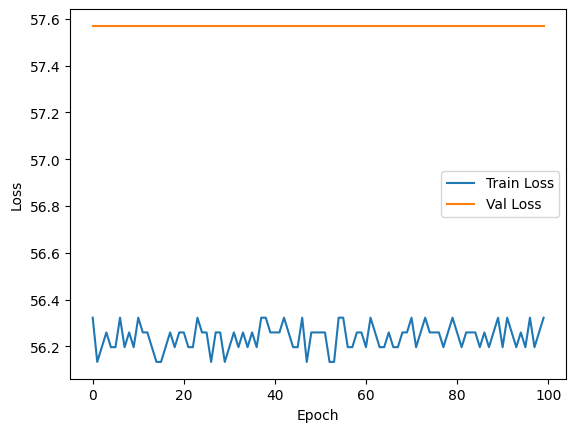

Accuracy: 45.14
F1 Score: 0.62


In [73]:
# Split your data into training and validation sets
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=42)

# Initialize a list to store the losses for each epoch
train_losses = []
val_losses = []

# Train the model
for epoch in range(100):  # Increase the number of epochs
    epoch_train_losses = []
    for inputs, targets in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Save the loss for this batch
        epoch_train_losses.append(loss.item())

    # Save the average loss for this epoch
    train_losses.append(sum(epoch_train_losses) / len(epoch_train_losses))

    # Evaluate on the validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs.squeeze(), y_val_tensor)
    val_losses.append(val_loss.item())
    model.train()

    # Print the losses for this epoch
    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

# Plot the losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs.squeeze() > 0.5).float()
    accuracy = (predicted == y_test_tensor).float().mean()
    print('Accuracy: %.2f' % (accuracy*100))

# Calculate and print the F1 score
f1 = f1_score(y_test_tensor, predicted)
print('F1 Score: %.2f' % f1)

In [164]:
# Store all the features in a CSV file
node_features.to_csv('data/node_features_extended.csv')